# PART 1: MODEL EXPLANATION AND GENERAL IDEA OF THE DEVELOPMENT OF THE EXAM

This notebook presents the implementation of the exam project for the Deep Learning course (June 2025 session).
The code strictly follows the structure and reasoning provided in the written exam, and is organized to reflect the required points (1–6) clearly.

All necessary preprocessing, model training, evaluation, and hyperparameter tuning steps are self-contained and runnable in Google Colab, without requiring manual data upload or Google Drive mounting.

Any changes from the written version are explicitly indicated with the tag "CHANGE" and properly motivated.
Final performance is reported only for completeness, to show the generalization ability of the model.



---



LINK for the project: https://colab.research.google.com/drive/12b1CW9tA3lqU1vl4_dx59b89Gmb785TL?usp=sharing

The notebook works in around 6 minutes

# IMPORT OF LIBRARIES AND DATASET


In [ ]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk import download
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Concatenate
)
from tensorflow.keras.optimizers import Adam


# download of stopwords for text preprocessing
download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


import dataset so that it is not linked to drive


In [ ]:
!wget -O input_data.pkl https://frasca.di.unimi.it/MLDNN/input_data.pkl
data = pd.read_pickle('input_data.pkl')
data.head()

--2025-07-06 13:50:01--  https://frasca.di.unimi.it/MLDNN/input_data.pkl
Resolving frasca.di.unimi.it (frasca.di.unimi.it)... 159.149.130.139
Connecting to frasca.di.unimi.it (frasca.di.unimi.it)|159.149.130.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3390300 (3.2M)
Saving to: ‘input_data.pkl’

input_data.pkl      100%[===================>]   3.23M  --.-KB/s    in 0.1s    

2025-07-06 13:50:03 (23.1 MB/s) - ‘input_data.pkl’ saved [3390300/3390300]



,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
88526,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
42019,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
80574,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
27131,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
63857,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


# PART 2, PREPROCESSING OF DATA

before preprocessing check if there are missing values

In [ ]:
data.isnull().sum()

,0
Hotel_Address,0
Review_Date,0
Average_Score,0
Hotel_Name,0
Reviewer_Nationality,0
Hotel_number_reviews,0
Reviewer_number_reviews,0
Review_Score,0
Review,0
Review_Type,0


no missing values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13772 entries, 88526 to 61379
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hotel_Address            13772 non-null  object 
 1   Review_Date              13772 non-null  object 
 2   Average_Score            13772 non-null  float64
 3   Hotel_Name               13772 non-null  object 
 4   Reviewer_Nationality     13772 non-null  object 
 5   Hotel_number_reviews     13772 non-null  int64  
 6   Reviewer_number_reviews  13772 non-null  int64  
 7   Review_Score             13772 non-null  float64
 8   Review                   13772 non-null  object 
 9   Review_Type              13772 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.7+ MB




---



PREPROCESSING OF HOTEL_NAMES AND REVIEWER_NATIONALITY (together because it's the same preprocessing)

I said in the exam that i would have checked the number of names of the hotels, and the same for the nationalities, in order to decide what preprocessing strategy to use: dictionary or onehotencoding.

In [ ]:
data["Hotel_Name"].value_counts(), data["Reviewer_Nationality"].value_counts()

(Hotel_Name
 Britannia International Hotel Canary Wharf    238
 Strand Palace Hotel                           126
 Copthorne Tara Hotel London Kensington        113
 Grand Royale London Hyde Park                 107
 Hilton London Metropole                       107
                                              ... 
 Hotel Silver                                    1
 Edouard 7 Paris Op ra                           1
 The Ritz Carlton Vienna                         1
 Hotel La Spezia Gruppo MiniHotel                1
 Hotel Am Stephansplatz                          1
 Name: count, Length: 1366, dtype: int64,
 Reviewer_Nationality
 United Kingdom               6241
 United States of America      692
 Australia                     458
 Saudi Arabia                  396
 United Arab Emirates          396
                              ... 
 St Pierre and Miquelon          1
 British Virgin Islands          1
 Abkhazia Georgia                1
 Vanuatu                         1
 Maldives    

they are a lot, so i'll create a dictionary to uniquely identify them as integers

In [ ]:
# preprocessing of Hotel_Name and Reviewer_Nationality
for col in ['Hotel_Name', 'Reviewer_Nationality']:
    unique_vals = data[col].unique()
    val_to_id = {val: i for i, val in enumerate(unique_vals)}
    data[col + '_id'] = data[col].map(val_to_id)

# check if we are doing right
print(data['Hotel_Name'].head())
print(data['Reviewer_Nationality'].head())

88526    Copthorne Tara Hotel London Kensington
42019    BEST WESTERN Maitrise Hotel Maida Vale
80574                   Catalonia Ramblas 4 Sup
27131                Hyatt Regency Paris Etoile
63857           Best Western PLUS Epping Forest
Name: Hotel_Name, dtype: object
88526     United Kingdom 
42019     United Kingdom 
80574     United Kingdom 
27131     United Kingdom 
63857     United Kingdom 
Name: Reviewer_Nationality, dtype: object




---



TEXTUAL column: Review

First step:

*   remove non significant words,
*   replace “-“ with white spaces,
*   lowercase everything,
*   split the words according to spaces between them.








In [ ]:
# function created to get minimum length of the words, if they are only consonants erase, all of this to get significant words
def is_sensible(word):
    if not re.search(r'[aeiou]', word): return False
    if len(word) < 3: return False
    if re.search(r'(.)\1{2,}', word): return False
    return True

def get_words(text):
    if pd.isnull(text): return []
    text = text.replace('--', ' ')
    words = text.split()
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]
    words = [w.lower() for w in words if w.isalpha()]
    words = [w for w in words if w not in stop_words]
    words = [w for w in words if is_sensible(w)]
    return words

Second step:
create a dictionary of the unique words







In [ ]:
all_words = data['Review'].apply(get_words)
flat_words = [word for sublist in all_words for word in sublist]
unique_words = np.unique(flat_words)
unique_word_index = {word: i for i, word in enumerate(unique_words)}

THIRD STEP IS THE CREATION OF SEQUENCES OF WORDS WITH A MAX LENGTH, BUT I CANNOT DO IT NOW, SINCE IT IS GOING TO CREATE DATA LEAKAGE! we need to apply it after the split in train and test, because if we apply to all, we are adapting the padding also to the validation set (also the test), that is going to corrupt the model.

(I just report here what we'll see later in the section of the model and cross validation)


In [ ]:
# X_text_train = pad_sequences(X_text_trainval[train_idx], maxlen=max_len)
# X_text_val = pad_sequences(X_text_trainval[val_idx], maxlen=max_len)

In [ ]:
# print the result we have up to now
print(f"Total words: {len(flat_words)}")
print(f"Unique words: {len(unique_words)}")
print(f"First 20 unique words: {unique_words[:20]}")
print(f"First 20 word-index pairs: {list(unique_word_index.items())[:20]}")

Total words: 185878
Unique words: 11056
First 20 unique words: ['aal' 'aback' 'abadoneded' 'abandoned' 'abatement' 'abbey' 'abd'
 'abdulrahim' 'abfluss' 'abig' 'ability' 'abit' 'able' 'abled' 'abroad'
 'abrubt' 'abrupt' 'abruptly' 'absence' 'absent']
First 20 word-index pairs: [(np.str_('aal'), 0), (np.str_('aback'), 1), (np.str_('abadoneded'), 2), (np.str_('abandoned'), 3), (np.str_('abatement'), 4), (np.str_('abbey'), 5), (np.str_('abd'), 6), (np.str_('abdulrahim'), 7), (np.str_('abfluss'), 8), (np.str_('abig'), 9), (np.str_('ability'), 10), (np.str_('abit'), 11), (np.str_('able'), 12), (np.str_('abled'), 13), (np.str_('abroad'), 14), (np.str_('abrubt'), 15), (np.str_('abrupt'), 16), (np.str_('abruptly'), 17), (np.str_('absence'), 18), (np.str_('absent'), 19)]




---



ERASE columns that are not needed:

*   Hotel_Address
*   Average_Score (there wasn't in the text of the exam)
*   Review_Type (As said in the exam it is going to bring data leakage if we keep it in the dataset)



But, before doing it, I just want to see if there is a threshold between Review_Score and Review_Type

In [ ]:
print(data.groupby('Review_Type')['Review_Score'].agg(['min', 'max']))

             min   max
Review_Type           
Bad_review   2.5   6.9
Good_review  7.0  10.0


Clearly the threshold is 0.7, so now I drop the column review score from the dataset and it is possible to reconstruct it from the predictions, without involving it in the training process.

In [ ]:
columns_to_drop = ["Hotel_Address", "Average_Score", "Review_Type"]
data = data.drop(columns=columns_to_drop)



---



Preprocessing of the column Hotel_number_reviews

**CHANGE**: I initially stated that I would leave Hotel_number_reviews as-is, assuming the values would not vary too much.

**MOTIVATION**: After inspecting the data with .describe(), I realized the range goes from very small numbers (e.g., 1) to over 5000.
This wide range can negatively affect model training due to unbalanced gradients across features.
For this reason, I applied standard scaling (StandardScaler) to ensure numerical stability for the model.

In [ ]:
data['Hotel_number_reviews'].value_counts(), data['Hotel_number_reviews'].describe()

(Hotel_number_reviews
 9086    238
 9568    126
 7105    113
 6539    107
 6977    107
        ... 
 511       1
 121       1
 234       1
 798       1
 470       1
 Name: count, Length: 1085, dtype: int64,
 count    13772.000000
 mean      2851.855940
 std       2388.518859
 min         43.000000
 25%       1200.000000
 50%       2215.000000
 75%       3802.000000
 max      16670.000000
 Name: Hotel_number_reviews, dtype: float64)

SAME REASONING AS PAD_SEQUENCES, HERE I CANNOT APPLY THE STANDARD SCALER TO EVERYTHING, BECAUSE, BY DOING SO, WE ARE GOING TO SEE ALL THE DATA, AND SO WE'LL HAVE DATA LEAKAGE.

I just report what we'll see in the next section of the creation of the model and kfold.

**IMPORTANT**: the method that is inside of the kfold applies the standard scaler to the columns that I decided to preprocess with this method, that are:

features_numerical = [
    'Review_Date_ordinal',
    'Hotel_number_reviews',
    'Reviewer_number_reviews',
]

In [ ]:
# scaler = StandardScaler()
# X_num_train = scaler.fit_transform(X_num_trainval[train_idx])
# X_num_val = scaler.transform(X_num_trainval[val_idx])



---



Preprocessing of Review_date

**CHANGE**: The column `Review_date` has been converted using `toordinal()` (number of days since 01/01/0001) and then scaled with standardscaler to preserve the internal statistical structure, (applied with the method described before).  
**MOTIVATION**: I decide to use this approach because it provides a continuous and consistent numerical representation of dates, which improves the model's ability to interpret temporal information. In contrast, simply removing slashes to get values like `20230614` does not reflect the actual time distance between dates. The idea in the exam was to bring them to continuous values, but I didn't remember at that moment how we learned to handle them in the first module of the course (the part of ML)

In [ ]:
from datetime import datetime

data['Review_Date'] = pd.to_datetime(data['Review_Date'])
data['Review_Date_ordinal'] = data['Review_Date'].apply(lambda x: x.toordinal())

In [ ]:
# scaler = StandardScaler()
# X_num_train = scaler.fit_transform(X_num_trainval[train_idx])
# X_num_val = scaler.transform(X_num_trainval[val_idx])



---



Preprocessing of Reviewer_number_reviews

**CHANGE**: In the exam description, I stated that 6 features would be used as tabular input to the MLP.  
**MOTIVATION**: Upon inspecting the actual dataset, I found that the column `Reviewer_number_reviews`, though not mentioned earlier, contains useful numerical information about the experience of the reviewer.  
Its maximum value is 211 and its scale is moderate, so it has been included in the final tabular input without scaling, bringing the total number of features to 7.

In [ ]:
data['Reviewer_number_reviews'].describe()

,Reviewer_number_reviews
count,13772.000000
mean,6.711952
std,10.100721
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,211.000000


In [ ]:
# scaler = StandardScaler()
# X_num_train = scaler.fit_transform(X_num_trainval[train_idx])
# X_num_val = scaler.transform(X_num_trainval[val_idx])

scaled as the other explained before



---



Preparation of the input, we have features_numerical that are the ones over which I am going to apply Standardscaler(). The categorical are the ones that I have translated into integers with the dictionary.

we can also see the preprocessing of the Label, that is Review_Score

In [ ]:
features_numerical = [
    'Review_Date_ordinal',
    'Hotel_number_reviews',
    'Reviewer_number_reviews',
]

features_categorical = [
    'Hotel_Name_id',
    'Reviewer_Nationality_id',
]
data['seq'] = all_words.apply(lambda words: [unique_word_index[word] for word in words if word in unique_word_index])

# definition of the "blochs" of the dataset, that will be splitted separetely and then recombined.
X_text_all = data['seq'].values
X_num_all = data[features_numerical].values.astype('float32')
X_cat_all = data[features_categorical].values.astype('float32')
y_all = (data['Review_Score'] / 10.0).values.astype('float32')

# PART 3,4,5: Configuration of the model, with loss, output layer, parameter grid

**Technical Design Choices of the Model**

The architecture was designed to be both effective and efficient, leveraging well-established deep learning practices. Below are the main technical choices and justifications:

* Embedding layer: The Embedding layer learns word representations from scratch. No pretrained embeddings (e.g., GloVe) are used, keeping the setup self-contained and avoiding external dependencies. The embedding weights are initialized using the Glorot (Xavier) uniform initializer, which is the default in Keras when no explicit initializer is provided. This helps maintain a stable variance of activations throughout the network. (As stated in the exam)

* Bidirectional LSTM: A Bidirectional(LSTM) layer is employed to process the text sequences. The LSTM captures long-term dependencies, while bidirectionality allows learning from both forward and backward temporal contexts. The number of units (n_units = 32) balances model expressiveness with training efficiency. The internal weights of the LSTM (kernel, recurrent, and bias) also use Glorot and orthogonal initializations by default in Keras, ensuring good convergence.

**CHANGE**: In the BiLSTM layer, I retained the default activations: tanh for the candidate state and sigmoid for the gating mechanisms.

**MOTIVATION**: These are standard and stable choices for recurrent architectures, paired with Glorot (Xavier) initialization for the weights
* Dropout: Dropout is applied after the LSTM layer to prevent overfitting. The dropout rate is tunable (dropout_rate) and follows standard ranges (0.3–0.5).

* Tabular branch: Structured inputs (both numerical and categorical) are passed through a small feedforward block with ReLU activations. These layers are lightweight but expressive enough to model interactions in the tabular features.

* Dense layers and batch normalization: After concatenation of the textual and tabular features, a sequence of dense layers is used to enable interaction between modalities. BatchNormalization is applied to stabilize and accelerate training. All Dense layers use ReLU activation, except for the final layer, which uses sigmoid to constrain the output in the range [0, 1] – consistent with the normalized target (Review Score / 10).

**CHANGE**: in the exam I've said that I was going to use sigmoid activation for the hidden layers of MLP, but I implemented RELU. Consequently I changed also the activation function from xavier/Glorot to HE uniform

**MOTIVATION**: ReLu is a well known activation function that reduces the effects of gradient vanishing and exploding when we compute the update of the weights with backpropagation. He uniform kernel initializer is known to work well with ReLu activation function, it shows a more stable beahaviour.

* Loss and optimizer: The model is trained with the Mean Squared Error (MSE) loss, suitable for regression tasks. The Adam optimizer is used with a tunable learning rate (lr). Adam combines the benefits of momentum and adaptive learning rate, and is known to perform well in most practical scenarios.

In [ ]:
def build_model(embedding_dim=64, n_units=32, dropout_rate=0.3, lr=0.001, max_len=100):
    text_input = Input(shape=(max_len,), name='text_input')
    emb = Embedding(input_dim=len(unique_word_index), output_dim=embedding_dim, input_length=max_len)(text_input)
    x = Bidirectional(LSTM(n_units))(emb)
    x = Dropout(dropout_rate)(x)

    num_input = Input(shape=(X_num_all.shape[1] + X_cat_all.shape[1],), name='num_input')
    n = Dense(32, activation='relu')(num_input)

    concat = Concatenate()([x, n])

    concat = BatchNormalization()(concat)
    concat = Dense(64, activation='relu', kernel_initializer='he_uniform')(concat)
    concat = Dropout(0.3)(concat)  # ✅ Aggiungi Dropout qui

    concat = Dense(32, activation='relu', kernel_initializer='he_uniform')(concat)
    concat = BatchNormalization()(concat)  # ✅ E magari anche qui
    concat = Dropout(0.3)(concat)
    output = Dense(1, activation='sigmoid')(concat)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model



**Hyperparameter Selection Explanation**


The grid search was performed over a limited but reasonable set of hyperparameter combinations.

Some hyperparameters (such as n_units, batch_size, and epochs) were fixed to a single value to speed up the training process and ensure the notebook completes execution within a few minutes, as required by the exam. However, the selected values are consistent with common practices and provide reasonable robustness for a model that combines LSTM-based text processing with tabular inputs.

The choices were guided by the following considerations:

* embedding_dim ∈ {32, 64}: typical values for embeddings trained from scratch on moderately sized vocabularies;

* dropout_rate ∈ {0.3, 0.5}: common values to mitigate overfitting while allowing effective learning;

* learning_rate ∈ {0.001, 0.0005}: standard values that work well with the Adam optimizer;

* max_len ∈ {100, 200}: balances shorter and longer reviews while avoiding excessive padding;

* n_units = 32: provides a good trade-off between learning capacity and computational efficiency;

* batch_size = 64,
* epochs = 2: chosen to keep the grid search lightweight, but adjustable in the final training phase.

Although some parameters are fixed, the code structure remains modular and easily extendable to support broader hyperparameter tuning in future experiments under more flexible computational settings.

In [ ]:
# grid of parameters for gridsearch
param_grid = {
    'embedding_dim': [32, 64],
    'n_units': [32],
    'dropout_rate': [0.3, 0.5],
    'lr': [0.001, 0.0005],
    'max_len': [100, 200],
    'batch_size': [64],
    'epochs': [2]
}



---



# PART 6: MODEL EVALUATION

**Data Split: Train / Validation / Test**


The dataset is split into three distinct subsets to prevent data leakage and ensure reliable model evaluation:

* **Training + Validation Set** (80%):
Used during model development. This set is further split into K folds (in our case, 2) to tune hyperparameters via cross-validation.

* **Test Set** (20%):
Held out from any training or validation process. It is used only once at the very end to report the final generalization performance. This ensures a fair estimate of the model’s true predictive ability on unseen data.

This separation guarantees that the model does not "see" the test set during tuning, aligning with standard machine learning best practices.

In [ ]:
# separate divisions of the "blochs" of the dataset as said before (I use this to recombine them then in the kfold correctly)
X_text_trainval, X_text_test, X_num_trainval, X_num_test, X_cat_trainval, X_cat_test, y_trainval, y_test = train_test_split(
    X_text_all, X_num_all, X_cat_all, y_all, test_size=0.2, random_state=42
)

**Grid Search + Cross-Validation**

* **Grid search**:  used to explore combinations of key hyperparameters such as embedding dimension, LSTM units, learning rate, dropout, and sequence length. Each combination is evaluated using K-Fold Cross-Validation:

* **Cross-Validation** (K=2):
The training+validation set is split into 2 folds. In each iteration, one fold is used for validation and the other for training. This reduces bias from a single train/val split and provides a more stable estimate of validation performance.

* **Mean Validation MSE**:
For each hyperparameter combination, the mean validation loss across folds is computed. The best configuration is selected based on the lowest average MSE.

This strategy helps prevent overfitting to a particular data subset and ensures robust model selection.


 ITERATION N: 1

Currently evaluating: dropout=0.3, embed_dim=32, units=32, lr=0.001, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


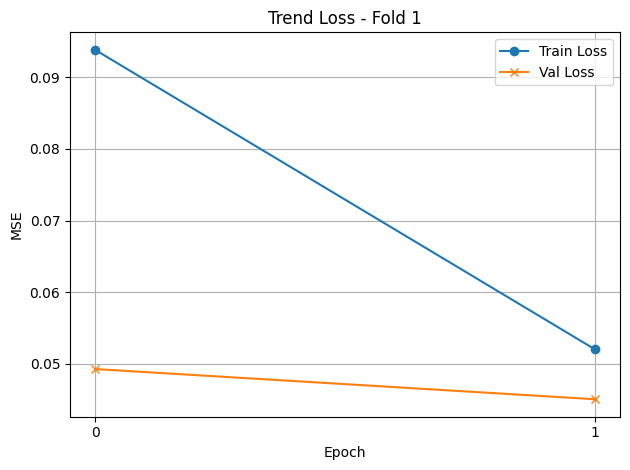

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


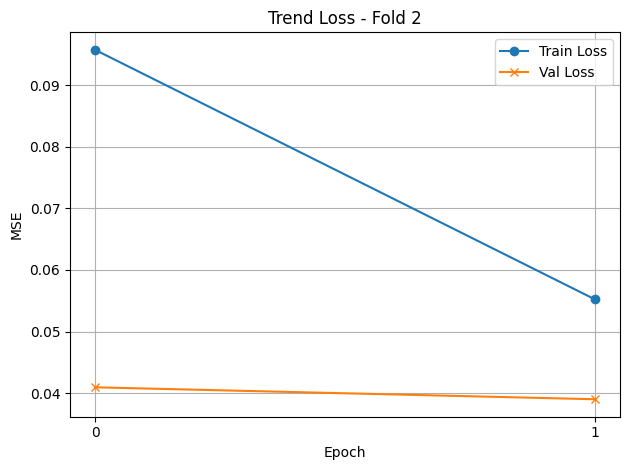

Average MSE: 0.0420


 ITERATION N: 2

Currently evaluating: dropout=0.3, embed_dim=32, units=32, lr=0.001, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


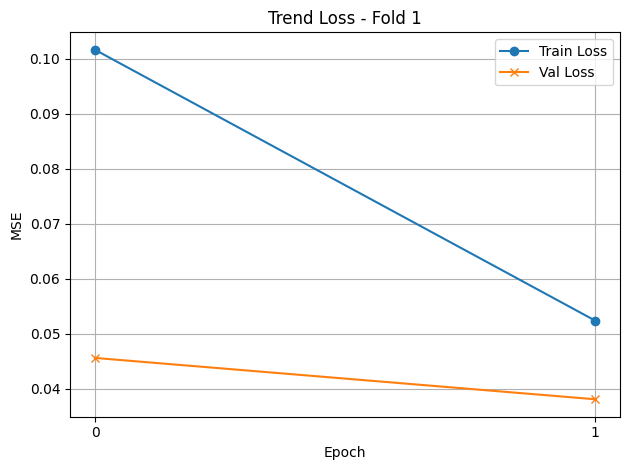

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


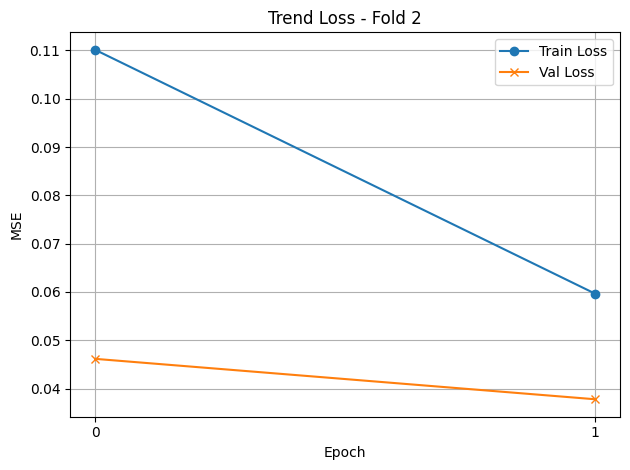

Average MSE: 0.0379


 ITERATION N: 3

Currently evaluating: dropout=0.3, embed_dim=32, units=32, lr=0.0005, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


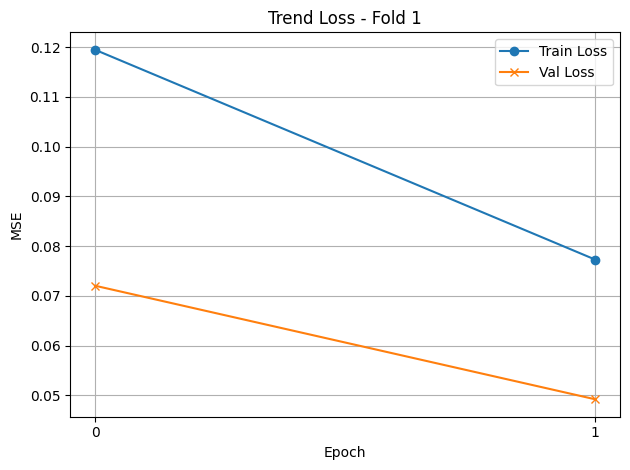

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


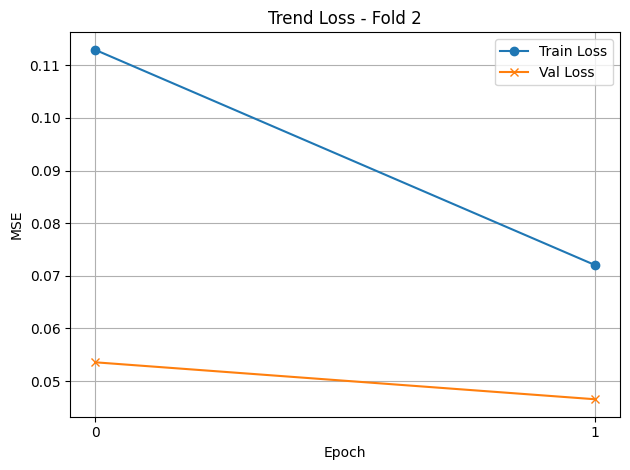

Average MSE: 0.0479


 ITERATION N: 4

Currently evaluating: dropout=0.3, embed_dim=32, units=32, lr=0.0005, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


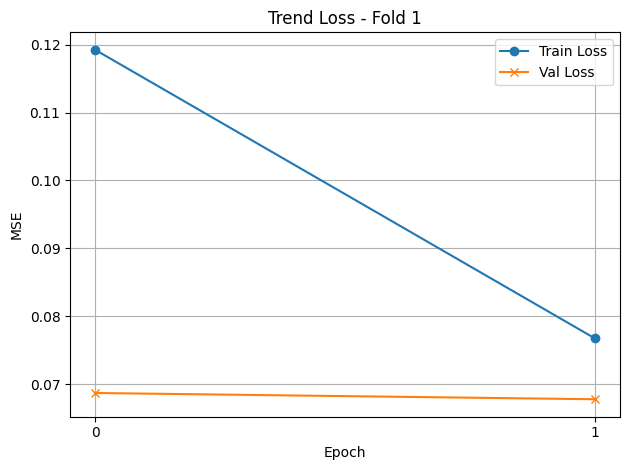

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


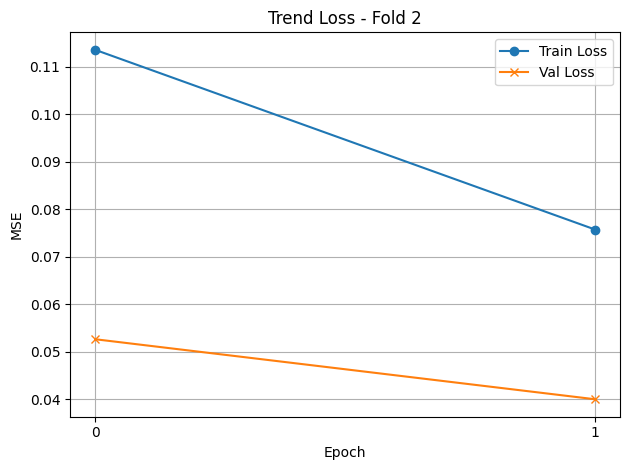

Average MSE: 0.0539


 ITERATION N: 5

Currently evaluating: dropout=0.3, embed_dim=64, units=32, lr=0.001, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


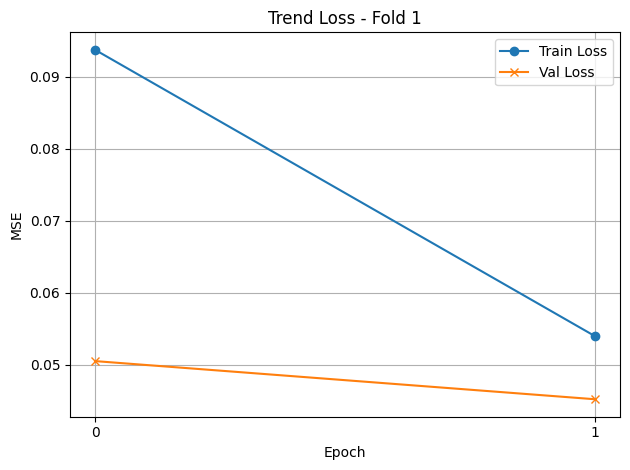

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


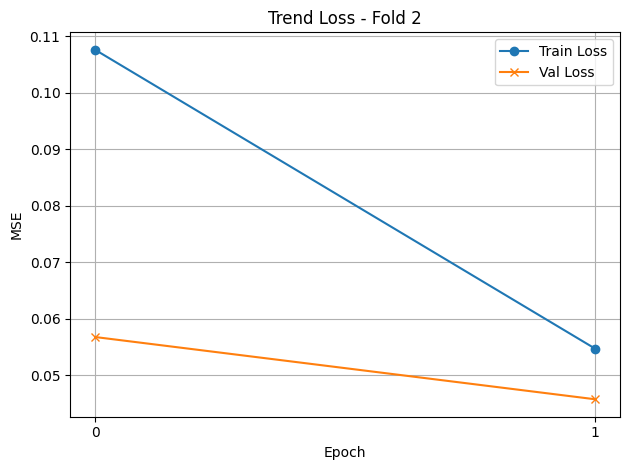

Average MSE: 0.0455


 ITERATION N: 6

Currently evaluating: dropout=0.3, embed_dim=64, units=32, lr=0.001, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


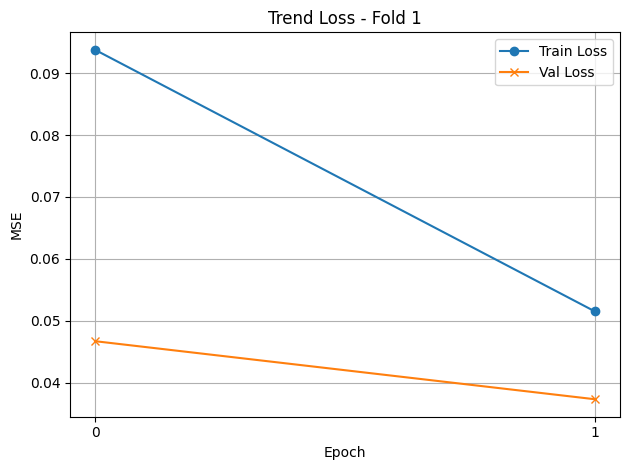

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


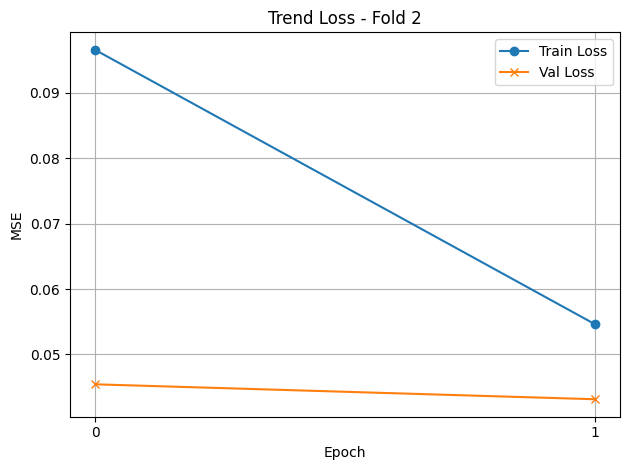

Average MSE: 0.0402


 ITERATION N: 7

Currently evaluating: dropout=0.3, embed_dim=64, units=32, lr=0.0005, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


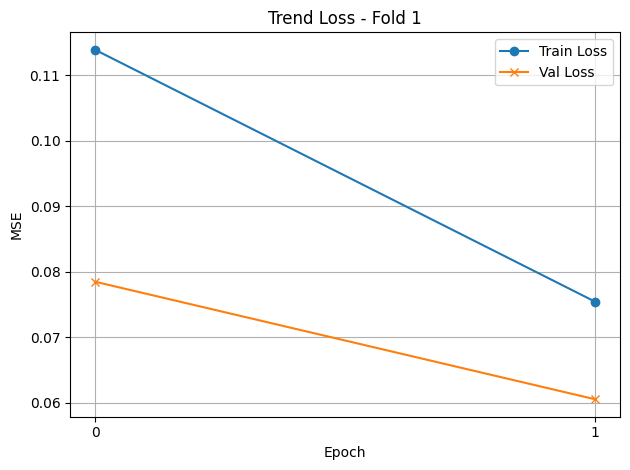

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


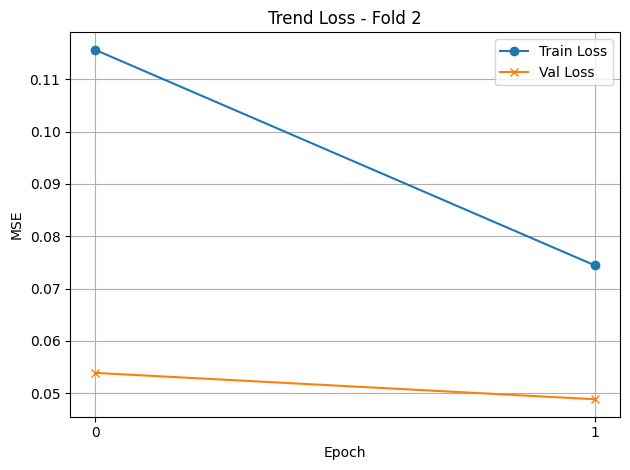

Average MSE: 0.0547


 ITERATION N: 8

Currently evaluating: dropout=0.3, embed_dim=64, units=32, lr=0.0005, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


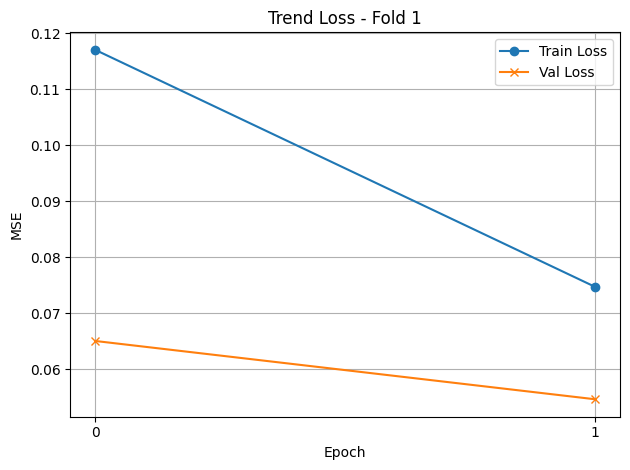

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


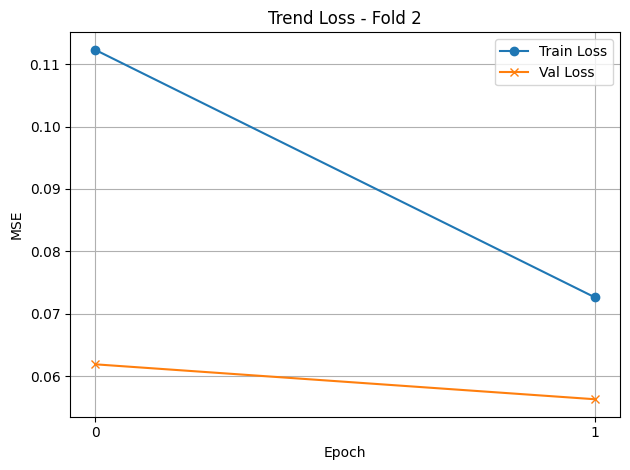

Average MSE: 0.0555


 ITERATION N: 9

Currently evaluating: dropout=0.5, embed_dim=32, units=32, lr=0.001, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


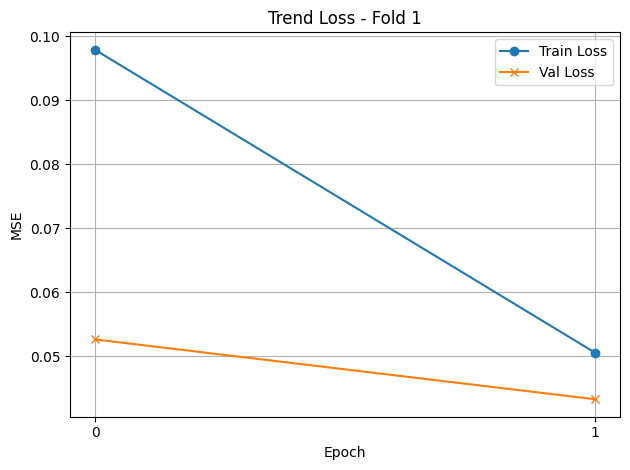

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


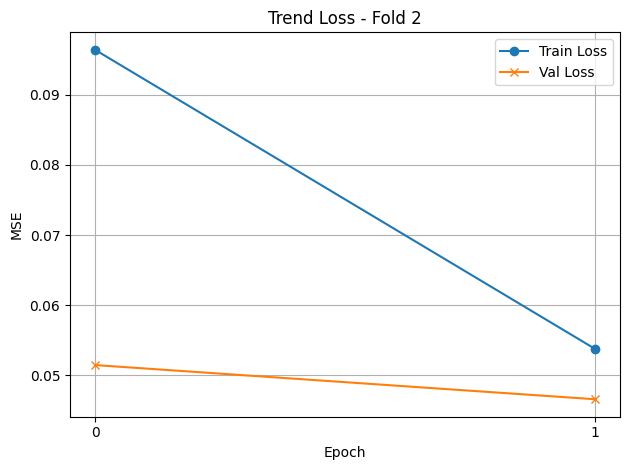

Average MSE: 0.0450


 ITERATION N: 10

Currently evaluating: dropout=0.5, embed_dim=32, units=32, lr=0.001, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


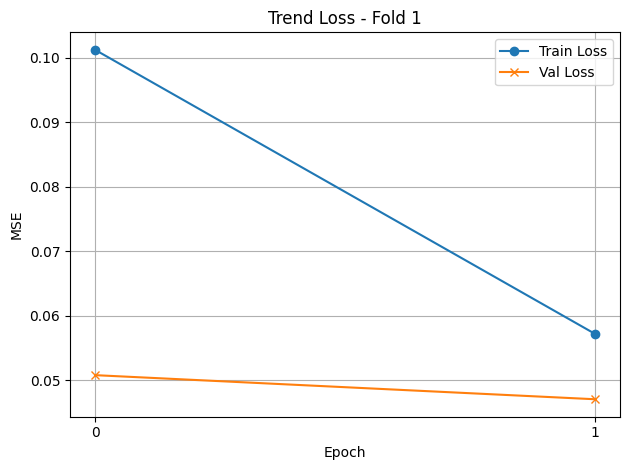

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


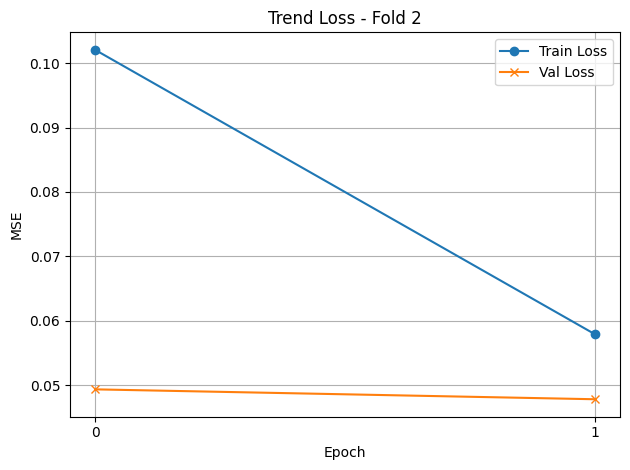

Average MSE: 0.0474


 ITERATION N: 11

Currently evaluating: dropout=0.5, embed_dim=32, units=32, lr=0.0005, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


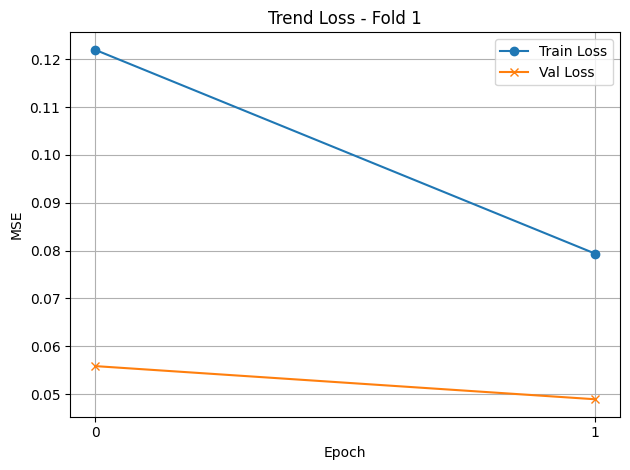

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


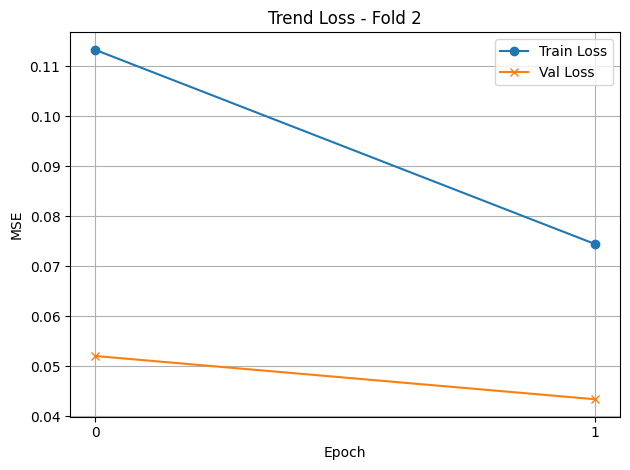

Average MSE: 0.0462


 ITERATION N: 12

Currently evaluating: dropout=0.5, embed_dim=32, units=32, lr=0.0005, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


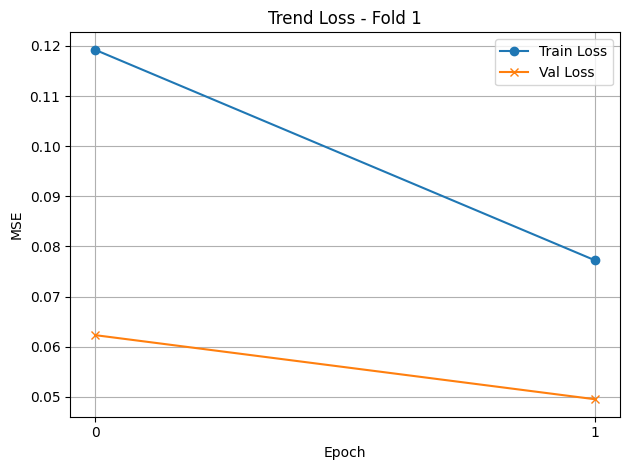

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


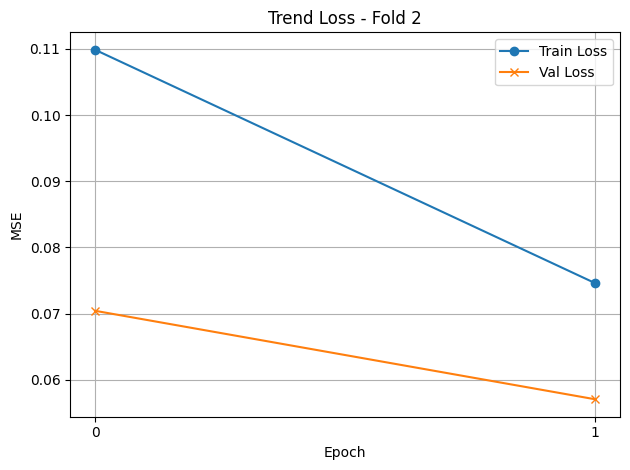

Average MSE: 0.0533


 ITERATION N: 13

Currently evaluating: dropout=0.5, embed_dim=64, units=32, lr=0.001, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


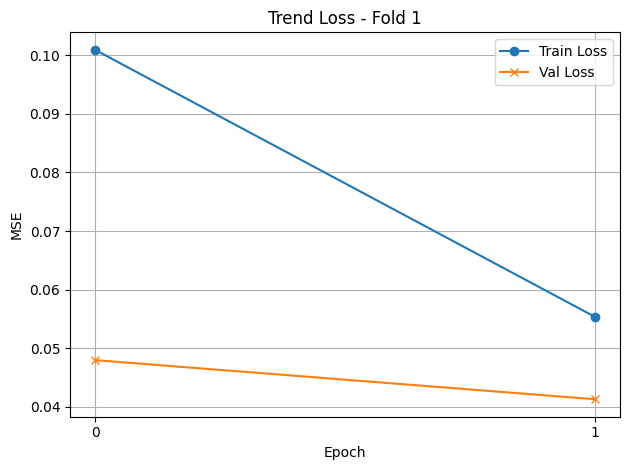

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


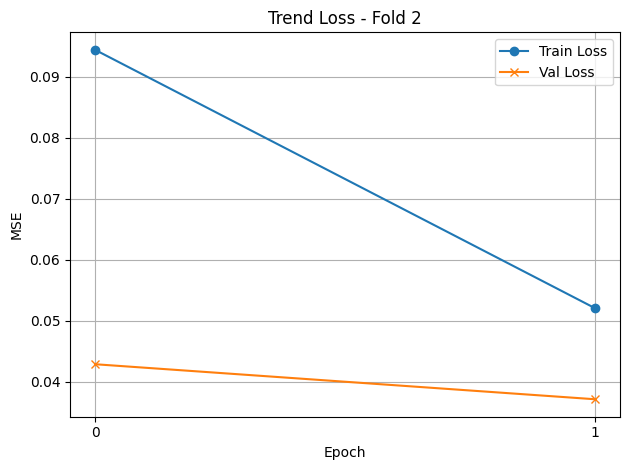

Average MSE: 0.0392


 ITERATION N: 14

Currently evaluating: dropout=0.5, embed_dim=64, units=32, lr=0.001, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


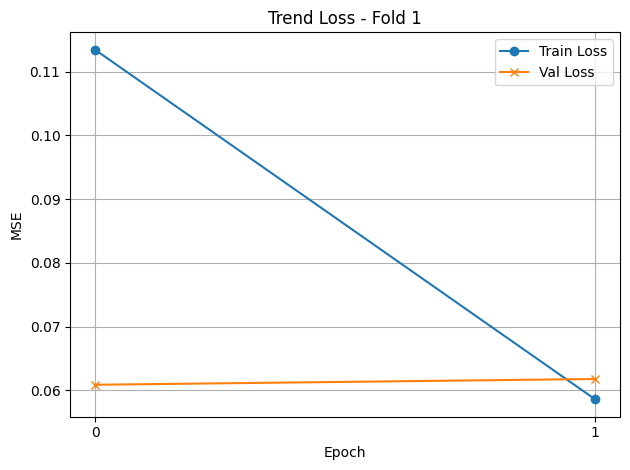

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


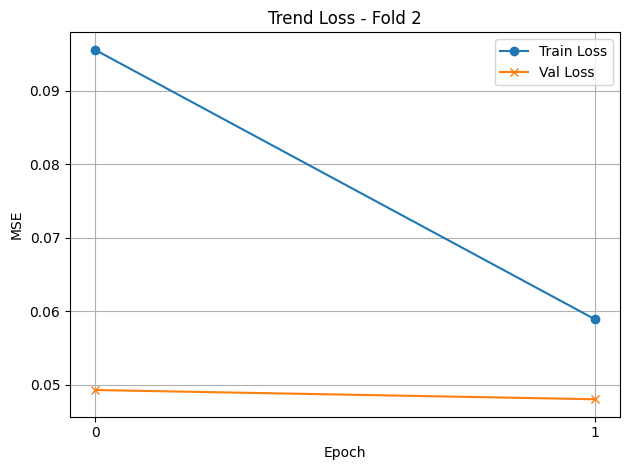

Average MSE: 0.0549


 ITERATION N: 15

Currently evaluating: dropout=0.5, embed_dim=64, units=32, lr=0.0005, maxlen=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


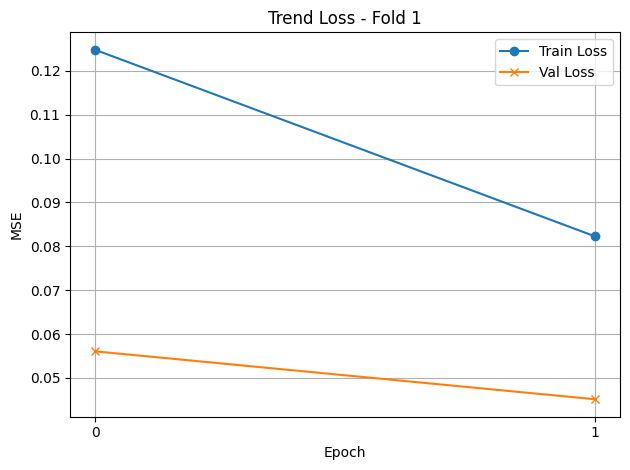

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


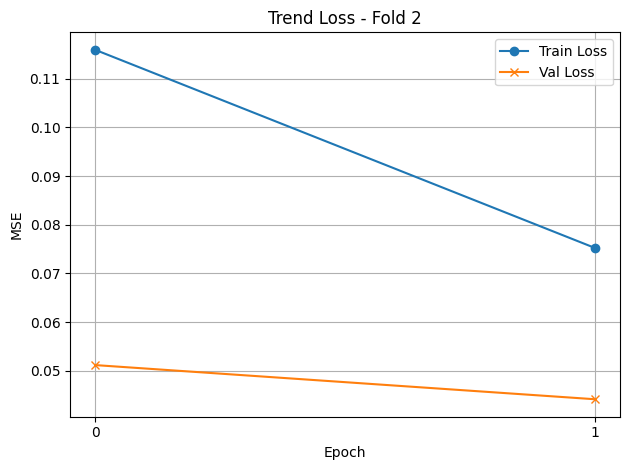

Average MSE: 0.0446


 ITERATION N: 16

Currently evaluating: dropout=0.5, embed_dim=64, units=32, lr=0.0005, maxlen=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


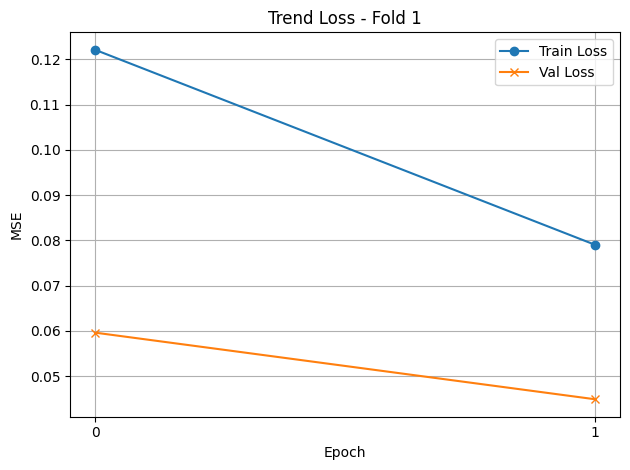

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


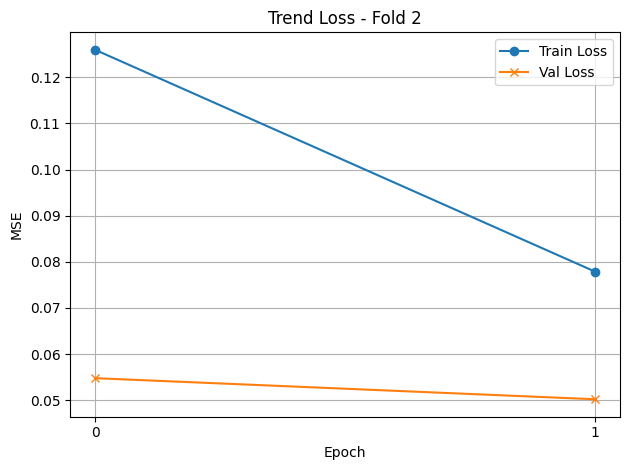

Average MSE: 0.0476



In [ ]:
best_score = float('inf')
best_params = None
all_val_scores = []

kf = KFold(n_splits=2, shuffle=True, random_state=42)
combo_count = 0

for dropout_rate in param_grid['dropout_rate']:
    for embedding_dim in param_grid['embedding_dim']:
        for n_units in param_grid['n_units']:
            for lr in param_grid['lr']:
                for max_len in param_grid['max_len']:
                    for batch_size in param_grid['batch_size']:
                        for epochs in param_grid['epochs']:

                            # print only at which iteration of the kfold we are
                            combo_count += 1
                            print("\n" + "="*40)
                            print(f" ITERATION N: {combo_count}")
                            print("="*40 + "\n")
                            print(f"Currently evaluating: dropout={dropout_rate}, embed_dim={embedding_dim}, units={n_units}, lr={lr}, maxlen={max_len}")

                            val_scores = []

                            for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_trainval)):
                                # padding of the sequences
                                X_text_train = pad_sequences(X_text_trainval[train_idx], maxlen=max_len)
                                X_text_val = pad_sequences(X_text_trainval[val_idx], maxlen=max_len)

                                # scaling the columns defined above (X_num that derives form X_num_all)
                                scaler = StandardScaler()
                                X_num_train = scaler.fit_transform(X_num_trainval[train_idx])
                                X_num_val = scaler.transform(X_num_trainval[val_idx])

                                # categorical columns transformed into dictionary
                                X_cat_train = X_cat_trainval[train_idx]
                                X_cat_val = X_cat_trainval[val_idx]

                                # concatenation to create the train
                                X_input_train = np.concatenate([X_num_train, X_cat_train], axis=1)
                                X_input_val = np.concatenate([X_num_val, X_cat_val], axis=1)

                                y_train = y_trainval[train_idx]
                                y_val_fold = y_trainval[val_idx]

                                model = build_model(
                                    embedding_dim=embedding_dim,
                                    n_units=n_units,
                                    dropout_rate=dropout_rate,
                                    lr=lr,
                                    max_len=max_len
                                )

                                history = model.fit([X_text_train, X_input_train], y_train,
                                                    validation_data=([X_text_val, X_input_val], y_val_fold),
                                                    batch_size=batch_size, epochs=epochs, verbose=0)

                                # plot the various folds
                                plt.figure()
                                plt.plot(history.history['loss'], marker='o', label='Train Loss')
                                plt.plot(history.history['val_loss'], marker='x', label='Val Loss')
                                plt.xticks(range(epochs))
                                plt.title(f'Trend Loss - Fold {fold+1}')
                                plt.xlabel('Epoch')
                                plt.ylabel('MSE')
                                plt.legend()
                                plt.grid(True)
                                plt.tight_layout()
                                plt.show()

                                val_loss = model.evaluate([X_text_val, X_input_val], y_val_fold, verbose=0)
                                val_scores.append(val_loss)

                            mean_val_loss = np.mean(val_scores)
                            all_val_scores.append(mean_val_loss)
                            print(f"Average MSE: {mean_val_loss:.4f}\n")

                            if mean_val_loss < best_score:
                                best_score = mean_val_loss
                                best_params = {
                                    'dropout_rate': dropout_rate,
                                    'embedding_dim': embedding_dim,
                                    'n_units': n_units,
                                    'lr': lr,
                                    'max_len': max_len,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }

**Final Model Training and Evaluation**

Final training is done with the best hyperparameters on the full trainval set, using 10 epochs to ensure convergence.

This final evaluation is crucial to measure how well the model generalizes, independently of the tuning process.

In [ ]:
print("\nBest hyperparameters found:")
print(best_params)
print(f"Best average MSE in CV: {best_score:.4f}")

# same process seen in the kfold
X_text_trainval_pad = pad_sequences(X_text_trainval, maxlen=best_params['max_len'])
X_text_test_pad = pad_sequences(X_text_test, maxlen=best_params['max_len'])

scaler_final = StandardScaler().fit(X_num_trainval)
X_num_trainval_scaled = scaler_final.transform(X_num_trainval)
X_num_test_scaled = scaler_final.transform(X_num_test)

X_input_trainval_final = np.concatenate([X_num_trainval_scaled, X_cat_trainval], axis=1)
X_input_test_final = np.concatenate([X_num_test_scaled, X_cat_test], axis=1)

model_final = build_model(
    embedding_dim=best_params['embedding_dim'],
    n_units=best_params['n_units'],
    dropout_rate=best_params['dropout_rate'],
    lr=best_params['lr'],
    max_len=best_params['max_len']
)




Best hyperparameters found:
{'dropout_rate': 0.3, 'embedding_dim': 32, 'n_units': 32, 'lr': 0.001, 'max_len': 200, 'batch_size': 64, 'epochs': 2}
Best average MSE in CV: 0.0379


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(




---



Visualization of the parameters of the model

In [ ]:
model_final.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_32        │ (None, 200, 32)   │    353,792 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_32    │ (None, 64)        │     16,640 │ embedding_32[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 64)        │          0 │ bidirectional_32… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 32)        │        192 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 96)        │          0 │ dropout_96[0][0], │
│ (Concatenate)       │                   │            │ dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96)        │        384 │ concatenate_32[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_129 (Dense)   │ (None, 64)        │      6,208 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 64)        │          0 │ dense_129[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_130 (Dense)   │ (None, 32)        │      2,080 │ dropout_97[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_130[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 1)         │         33 │ dropout_98[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 379,457 (1.45 MB)

 Trainable params: 379,201 (1.45 MB)

 Non-trainable params: 256 (1.00 KB)



---



Plotting explained above

HERE WE NEED TO RESCALE THE VALUES OF Y FROM [0,1] TO [0,10]

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.1002 - val_loss: 0.0408
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0363 - val_loss: 0.0317
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0264 - val_loss: 0.0223
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0217 - val_loss: 0.0253
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0187 - val_loss: 0.0184
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0163 - val_loss: 0.0198
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0152 - val_loss: 0.0183
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0138 - val_loss: 0.0193
Epoch 9/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0126 - val_loss: 0.0187
Epoch 10/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0118 - val_loss: 0.0184
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

MSE over the test set (rescaled to [0,10]): 1.8387


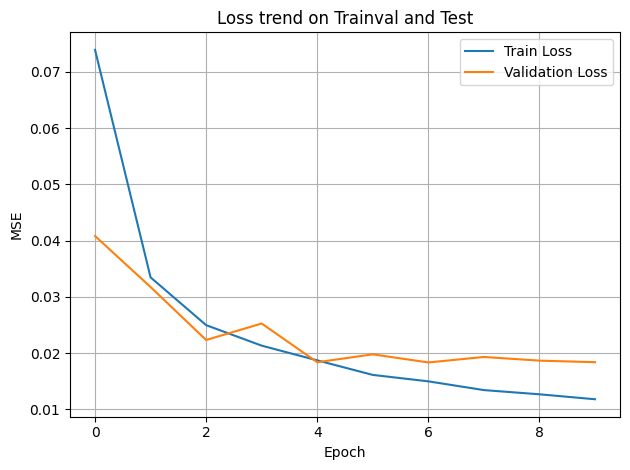

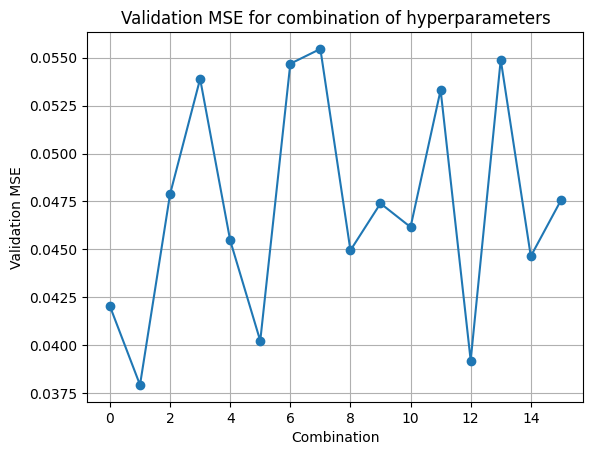

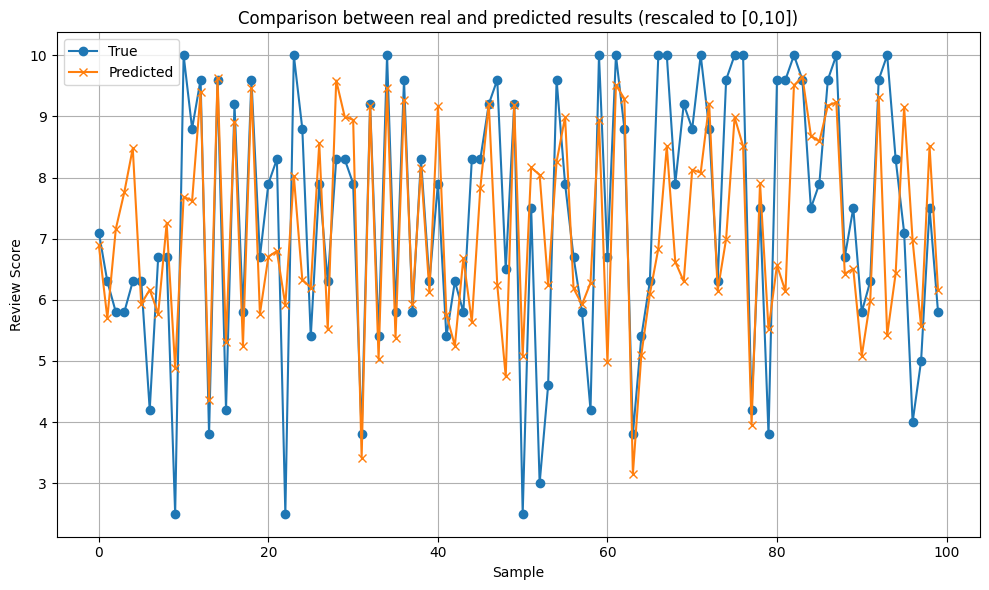

In [ ]:
final_epochs = 10  # addition of epochs for final evaluation
final_history = model_final.fit(
    [X_text_trainval_pad, X_input_trainval_final], y_trainval,
    validation_data=([X_text_test_pad, X_input_test_final], y_test),
    batch_size=best_params['batch_size'],
    epochs=final_epochs,
    verbose=1
)

# final prediction and rescaling to [0,10]
y_pred_scaled = model_final.predict([X_text_test_pad, X_input_test_final]).flatten()
y_pred_rescaled = y_pred_scaled * 10
y_test_rescaled = y_test * 10

mse_rescaled = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"\nMSE over the test set (rescaled to [0,10]): {mse_rescaled:.4f}")


# final plot training & validation loss
plt.figure()
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Loss trend on Trainval and Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation MSE for each combination of hyperparameters
plt.figure()
plt.plot(all_val_scores, marker='o')
plt.title('Validation MSE for combination of hyperparameters')
plt.xlabel('Combination')
plt.ylabel('Validation MSE')
plt.grid(True)
plt.show()

# comparison real vs predicted values(rescaled)
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:100], label='True', marker='o')
plt.plot(y_pred_rescaled[:100], label='Predicted', marker='x')
plt.title('Comparison between real and predicted results (rescaled to [0,10])')
plt.xlabel('Sample')
plt.ylabel('Review Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()